In [1]:
import sys
sys.path.append("../") # go to parent dir
import os
from pathlib2 import Path
import random
from test_instances.fair_sd_ts_test import FairSDTest
from test_instances.normal_ts_test import  NormalTSTest
from test_instances.normal_sd_ts_test import NormalSDTest
from thompson_sampling.normal_IG_ts import NormalThompsonSampling
from thompson_sampling.normal_IG_stochastic_dominance_ts import NormalStochasticDominance
import numpy as np
from normalBandits import NormalBandits
import pickle 
import matplotlib.pyplot as plt
import plot.plot_data_seperated as plt_sep

np.set_printoptions(threshold=np.nan)
np.set_printoptions(suppress=True)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})


def plot_all(test_cases):
    plt_sep.plot_delta_subjective_fair(test_cases)
    plt_sep.plot_subjective_min_e1(test_cases)
    plt_sep.plot_delta_smooth_fair(test_cases)
    plt_sep.plot_min_e1(test_cases)
    plt_sep.plot_average_total_regret(test_cases)
    plt_sep.plot_fairness_regret(test_cases)


def save_plot(name):
    i = 0
    name = 'fin_sep_data_' + name
    name_i = name + '_' + format(i) + '.png'
    while Path('/Users/antonm/Desktop/BachelorThesis/Plots/'+name_i).exists():
        i += 1
        name_i = name + '_' + format(i) + '.png'
    plt.savefig('/Users/antonm/Desktop/BachelorThesis/Plots/'+ name_i, bbox_inches='tight')


In [2]:
def plot_min_e1(test_cases):
    T = test_cases[0].T
    x = range(T)




    for test_ind, test in enumerate(test_cases):
        for e2_ind, e2 in enumerate(test.e2_arr):
            for delta_ind, delta in enumerate(test.delta_arr):
                if ALL or (e2 in E2_SELECTION and delta in DELTA_SELECTION and not((e2,delta) in LEAVE_OUT)):
                    if test.name == 'Fair SD TS':
                        algo_name = test.get_label_name(delta=delta, e2=e2)
                        y = test.min_e1[e2_ind, delta_ind]
                        explore_end_x = test.average_rounds_exploring[e2_ind, delta_ind]
                        if explore_end_x < T:
                            plt.plot(x, y, label=algo_name, marker='o', markevery=[int(explore_end_x)])
                        else:
                            plt.plot(x, y, label=algo_name)      
                    else: 
                        algo_name = test.get_label_name(delta=delta, e2=e2)
                        plt.plot(x, test.min_e1[e2_ind, delta_ind],label=algo_name)

    axes = plt.gca()

    if fix_y:               
        axes.set_ylim([ymin,ymax])
    else:
        axes.relim()
        # update ax.viewLim using the new dataLim
        axes.autoscale_view()
#         axes.set_yscale('log')

    plt.xlabel('$t$')
    plt.ylabel('min $\epsilon_1$ for $(\epsilon_1, \epsilon_2, \delta)-fairness$')
    name = 'min_e1_{}_'.format(T)+test_cases[0].bandits.data_set_name

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    save_plot(name)
    plt.show()


def plot_delta_smooth_fair(test_cases, start_index=0):
    T = test_cases[0].T
    x = range(T)

    for test in test_cases:
        #ds_name = test.bandits.data_set_name
        
       
        for e1_ind, e1 in enumerate(test.e1_arr):
           
            for e2_ind, e2 in enumerate(test.e2_arr):
                if ALL or (e2 in E2_SELECTION and (e1 in E1_SELECTION or ALL_E1)):

                    if test.name == 'Fair SD TS':
                            for delta_ind, delta in enumerate(test.delta_arr):

                                algo_name = test.get_label_name(e1=e1, delta=delta, e2=e2)
                                y = np.min(np.min(test.frac_smooth_fair[e1_ind, e2_ind, delta_ind], axis=1),
                                                axis=1)[start_index:]
                                explore_end_x = test.average_rounds_exploring[e2_ind, delta_ind]
                                if explore_end_x < T:
                                    plt.plot(x[start_index:], y, label=algo_name, marker='o', markevery=[int(explore_end_x)])
                                else:
                                    plt.plot(x[start_index:], y, label=algo_name)
                    else:
                        algo_name = test.get_label_name(e1=e1, e2=e2)
                        plt.plot(x[start_index:],
                                 np.min(np.min(test.frac_smooth_fair[e1_ind, e2_ind], axis=1), axis=1)
                                 [start_index:], label=algo_name)

                # xmin = np.amin(np.min(np.min(test.frac_subjective_smooth_fair[e1_ind, e2_ind], axis=1), axis=1))
                # ymin = np.min(np.min(test.frac_subjective_smooth_fair[e1_ind, e2_ind], axis=1), axis=1)
                # plt.plot(xmin, ymin)
                # plt.annotate((1 - d), xy=(2, 1), xytext=(3, 1.5),
                #              arrowprops=dict(facecolor='black', shrink=0.05),
                #          
    plt.xlabel('$t$')
    plt.ylabel('Smooth fair probability \n $(1-\delta)$')
    axes = plt.gca()

    axes.set_ylim([0,1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    name = 'delta_smooth_fair_{}'.format(T)
    save_plot(name)


    # bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
def n_info(test_cases):
    for test in test_cases:
        print test.name + 'n' + str(test.average_n[-1])
        print test.name + 'pi prediction' + str(np.average(test.curr_test.pi, axis=0) * T)
        
def plot_n(test):
    k = test.bandits.k
    y_pos = np.arange(k)
    plt.bar(y_pos, test.average_n[-1], align='center', alpha=0.5)
    plt.xticks(y_pos, y_pos)
    plt.ylabel('Average Number Selected')
    plt.xlabel('Arm')
    plt.show()


In [3]:
def get_tests(folder):
    ts_test = np.empty(4, dtype=object)
    sd_ts_test = np.empty(4, dtype=object)
    fair_sd_ts_test = np.empty(4, dtype=object)
    for i in range(4):
        ts_test[i] = []
        sd_ts_test[i] = []
        fair_sd_ts_test[i] = []
    comb = []
    for file in os.listdir("/Users/antonm/PycharmProjects/Fairness_in_Bandits/"+folder):
        if file.endswith(".file"):
            with open(os.path.join("/Users/antonm/PycharmProjects/Fairness_in_Bandits/"+folder, file), "rb") as f:
                test = pickle.load(f) 
                if test.T >= end_index and test.n_iter == n_iter:
                    if test.bandits.data_set_name == 'D0':
                        d = 0
                    elif test.bandits.data_set_name == 'D1':
                        d = 1
                    elif test.bandits.data_set_name == 'D2':
                        d = 2
                    elif test.bandits.data_set_name == 'D3':
                        d = 3
                    if test.name == 'TS':
                        ts_test[d].append(test)
                    elif test.name == 'SD  TS' or test.name == 'SD TS':
                        sd_ts_test[d].append(test)

                    elif test.name == 'Fair SD TS':
                        
#                         if (test.e2_arr[0], test.delta_arr[0]) in comb:
#                             print (test.e2_arr[0], test.delta_arr[0])
#                             print comb 
#                             os.remove(os.path.join("/Users/antonm/PycharmProjects/Fairness_in_Bandits/"
#                                                     +folder, file))
#                         else:
                        fair_sd_ts_test[d].append(test)
                        comb.append((test.e2_arr[0],test.delta_arr[0]))
                    else:
                        print 'unknwown test name'
                        
                # To sort the list in place...
    for i in range(4):
         fair_sd_ts_test[i].sort(key=lambda x: (x.e2_arr[0], x.delta_arr[0]), reverse=False)
    return ts_test, sd_ts_test, fair_sd_ts_test




def plot_smooth(d, s=True, min=True, ts=1, sd=1, fair=1):
    test_cases = []
    if ts:
        test_cases += ts_test[d] 
    if sd:
        test_cases += sd_ts_test[d] 
    if fair:
        test_cases += fair_sd_ts_test[d] 

    if s:
        plot_delta_smooth_fair(test_cases)
    if min:
        plot_min_e1(test_cases)

    

In [4]:
T = 10000
n_iter = 100.
end_index=T
folder_normal = 'normal_objects/new_normal_objects/'+str(T)
ymin=0
ymax=1

In [5]:
ts_test, sd_ts_test, fair_sd_ts_test = get_tests(folder_normal)


In [6]:
for i in range(4):
         fair_sd_ts_test[i].sort(key=lambda x: (x.e2_arr[0], x.delta_arr[0]), reverse=False)

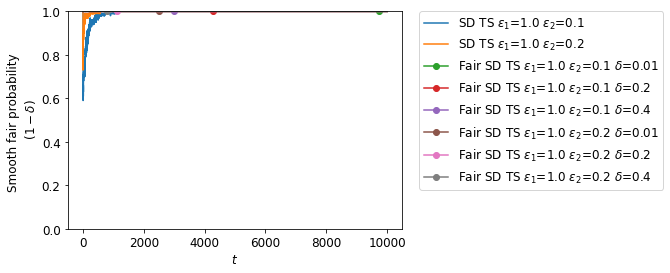

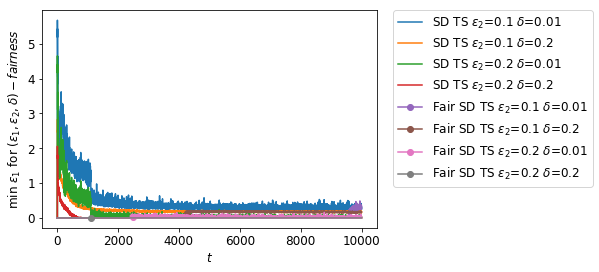

In [28]:
ALL = False 
ALL_E1 = True 
E1_SELECTION = []
E2_SELECTION =[0.1, 0.2]  #[0.0, 0.1, 0.2] #0.02
DELTA_SELECTION = [0.01, 0.2]#[0.0, 0.01, 0.2, 0.4]
LEAVE_OUT = []#[(0.1,0.01) ]

fix_y = False 

plot_smooth(0, ts=0, sd=1)

In [8]:
# sd_ts_test[0][0].curr_test.pi
# fair_sd_ts_test[0][1].curr_test.pi


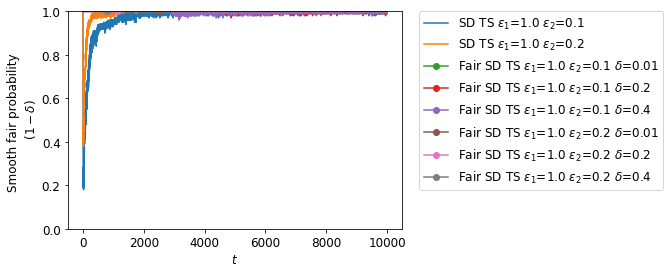

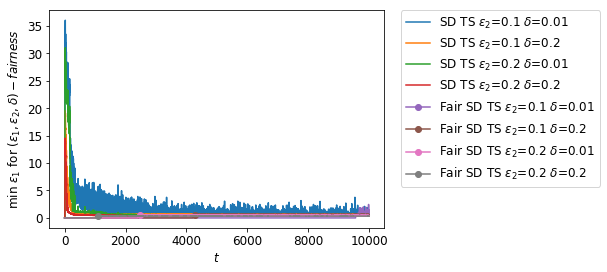

In [27]:
ALL = False
ALL_E1 = True 
E1_SELECTION = []
E2_SELECTION = [0.1, 0.2] #0.02
DELTA_SELECTION = [0.01, 0.2, 0.4]
LEAVE_OUT = [] #[(0.05,0.3) ]
LEAVE_OUT = [(0.2,0.4),(0.1,0.4),  ]

fix_y = False 

plot_smooth(1, ts=0, sd=1)

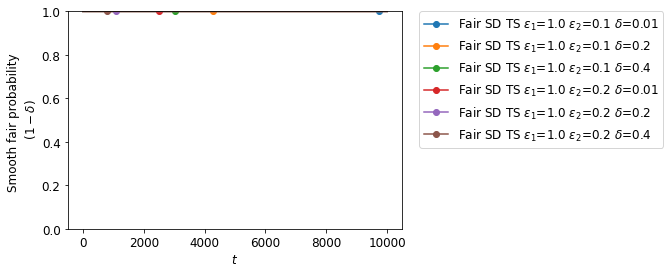

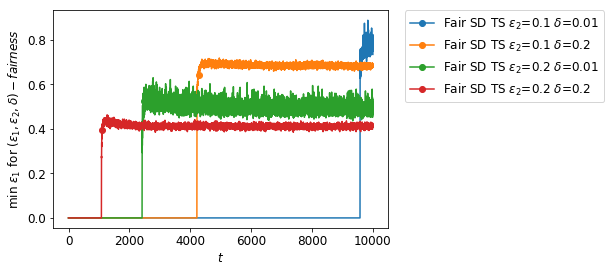

In [26]:
ALL = False 
ALL_E1 = True 
E1_SELECTION = []
E2_SELECTION =[0.1, 0.2]  #[0.0, 0.1, 0.2] #0.02
DELTA_SELECTION = [0.01, 0.2]#[0.0, 0.01, 0.2, 0.4]
LEAVE_OUT = []#[(0.1,0.01) ]

plot_smooth(2,ts=0, sd=0)

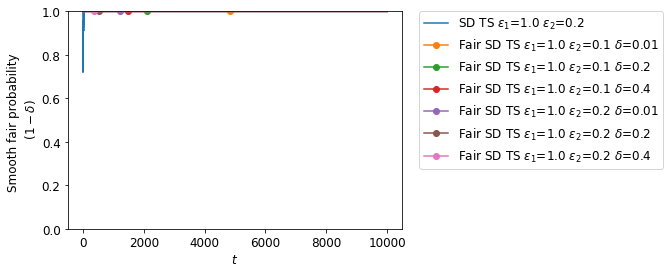

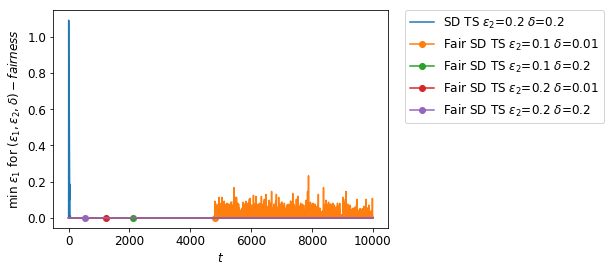

In [24]:
ALL = False 
ALL_E1 = True 
E1_SELECTION = []
E2_SELECTION =[0.1, 0.2]  #[0.0, 0.1, 0.2] #0.02
DELTA_SELECTION = [0.01, 0.2]#[0.0, 0.01, 0.2, 0.4]
LEAVE_OUT = []#[(0.1,0.01) ]

plot_smooth(3, ts=0, sd=1)

In [12]:
fair_sd_ts_test[3][0].curr_test.pi[-10:-1]

array([[0.515, 0.485],
       [0.516, 0.484],
       [0.524, 0.476],
       [0.483, 0.517],
       [0.501, 0.499],
       [0.491, 0.509],
       [0.485, 0.515],
       [0.498, 0.502],
       [0.496, 0.504]])

With low probability for $\epsilon_1$ \FSDT{} does not learn the underlyting mean optimal policy which, calculate the distance to  